In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bd-air-quality/Air Quality Data.csv


# Project workflow

This project utilizes the Supervised Machine Learning algorithms from python’s Scikit-learn library & DNNs. The model we hope to succeed in training is a regression model and below are the steps we will go through in this jupyter notebook for this project:

* Import the neccessary libraries and loading the data
* Data preprocessing
* Exploratory Data Ananlysis
* Model training and Evaluation
* Saving the model

# Import libraries and loading data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as formula
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing

In [3]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display

In [4]:
# get the name of the csv file 

file = r'/kaggle/input/bd-air-quality/Air Quality Data.csv'

# read the csv file into a pandas DataFrame using the pd.read_csv()
data = pd.read_csv(file)
data.head()

,time,mean_MYD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean,Station_mean_raw_PM2.5,Maximum Temperature,Minimum Temperature,Average Temperature,Heat Index,Rain Precipitation,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,1/1/2017,0.600190,231.5,26.0,16.0,20.5,NaN,0.0,6.9,50.21,NaN,1.2,16.3,73.17,Clear
1,1/2/2017,0.418893,209.6,27.0,16.0,20.9,27.1,0.0,6.9,65.25,NaN,1.4,16.8,72.88,Clear
2,1/3/2017,0.482987,181.9,27.0,16.8,21.4,27.1,0.0,9.2,169.75,NaN,1.7,14.4,69.74,Clear
3,1/4/2017,0.433491,127.7,26.1,16.0,20.8,NaN,0.0,11.4,279.21,NaN,2.0,0.2,67.64,Clear
4,1/5/2017,0.404293,206.8,24.0,15.8,19.6,NaN,0.0,10.3,294.58,NaN,1.2,20.0,79.39,Clear


# Data Preprocessing

In [5]:
cols_to_drop = ['Wind Gust','Heat Index','Conditions']
data = data.drop(cols_to_drop,axis=1)
# print out the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 12 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   time                                                              1476 non-null   object 
 1    mean_MYD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean  1476 non-null   float64
 2   Station_mean_raw_PM2.5                                            1476 non-null   float64
 3   Maximum Temperature                                               1476 non-null   float64
 4   Minimum Temperature                                               1476 non-null   float64
 5   Average Temperature                                               1476 non-null   float64
 6   Rain Precipitation                                                1476 non-null   float64
 7   Wind Speed                       

In [6]:
# check for duplicated values and null values
print('Are there any duplicated values in our data ? : {}\n'.format(data.duplicated().any()))
print('The total number of null values in each colum:')
display(data.isnull().sum())

Are there any duplicated values in our data ? : False

The total number of null values in each colum:


time                                                                0
 mean_MYD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean    0
Station_mean_raw_PM2.5                                              0
Maximum Temperature                                                 0
Minimum Temperature                                                 0
Average Temperature                                                 0
Rain Precipitation                                                  0
Wind Speed                                                          0
Wind Direction                                                      0
Visibility                                                          0
Cloud Cover                                                         0
Relative Humidity                                                   0
dtype: int64

# Exploratory Data Analysis

Before we start fitting a machine learning model on the data, we need to know much about the data by performing an Exploratory Data Analysis to gain insight from it. is simply describing the data by means of visualization. It involves asking questions about the data and answering them with the help of charts/graphs (graphical representation of the data). In this process, we will try to study the behavoir of the amount of pollutant (PM2.5 concentration) in the air and the relationship between other features. Below are some of the questions we will try to answer by analyzing the data, to know more about our dependent and independent variables:

* In which direction does polluted air/wind mostly move ?
* How do the other environmental factors affect the amount of PM2.5 concentration in the air ?

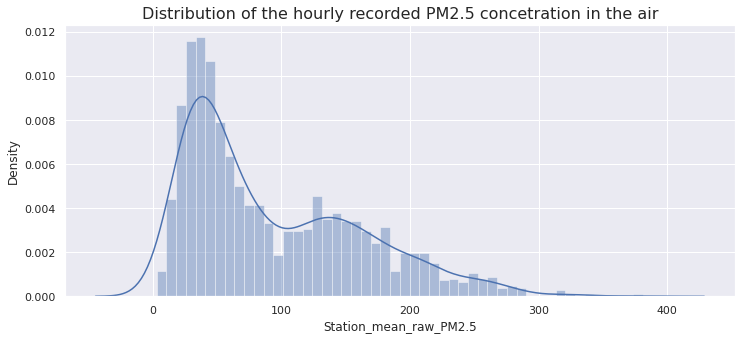

In [7]:

plt.figure(figsize=(12,5))
sns.distplot(data['Station_mean_raw_PM2.5'],bins=50)
plt.title('Distribution of the hourly recorded PM2.5 concetration in the air',
          fontsize=16)
plt.show()

In [8]:
#most important;  SO2     NO2      CO       O3      WSPM    

check for multicollinearity among variables and fit a regression model using statsmodels


In [9]:
cols_to_drop = ['time','Wind Direction','Minimum Temperature','Maximum Temperature']
newdata = data.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(newdata)
series_before = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before

const                                                               626.249862
 mean_MYD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean      1.185343
Station_mean_raw_PM2.5                                                4.769444
Average Temperature                                                   3.325032
Rain Precipitation                                                    1.451829
Wind Speed                                                            1.135452
Visibility                                                            4.627230
Cloud Cover                                                           4.023507
Relative Humidity                                                     3.357067
dtype: float64

# Model Training and Evaluation
# 

# Ensemble methods
For ensemble methods (DecisionTreeRegressor,RandomForestRegressor,and GradientBoostingRegressor),we include the pressure and rain features and we won't scale the predictor variables,neither would we log transform the outcome variable. At this part, model fitting and hyper-parameter tunning will be done at the same time. Instead of fitting the model with single parameters, we will straight away perform the grid search with multiple values for a parameter and find the best parameters for fitting the model on our data to get a satisfactory accuracy.

In [10]:
ensemble_data = data.drop(cols_to_drop,axis=1)

# we split the data into predictor variables and Outcome variable
X = ensemble_data.drop('Station_mean_raw_PM2.5',axis=1)
y = ensemble_data['Station_mean_raw_PM2.5']

In [11]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.3,random_state=42)

# DecisionTreeRegressor
we will now fit a decision tree regression model on the data and tune some of its parameters to increase the accuracy.

In [12]:
# we go ahead to use the ensemble methods as the LinearRegression model has a low accuracy
# on both the test and train data.
decision_tree = DecisionTreeRegressor(max_depth=5,
                                     max_features='auto',
                                     min_samples_split=3,
                                     min_samples_leaf=2)
decision_tree.fit(xtrain,ytrain)

DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=2,
                      min_samples_split=3)

In [13]:
# we now score the model
print('Score on train data: {}\n'.format(decision_tree.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(decision_tree.score(xtest,ytest)))

tree_pred = decision_tree.predict(xtest)
tree_mse = mean_squared_error(ytest,tree_pred)
tree_accuracy = r2_score(ytest,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('Overall model accuracy: {}'.format(tree_accuracy))

Score on train data: 0.8048786743008246

Score on test data: 0.7424485033227913

Root Mean Squared Error: 33.73785769309928

Overall model accuracy: 0.7424485033227913


In [14]:

# We now tune the parameters of the model to see if we can increase the accuracy
params = {'max_depth':[3,4,5,6,7],
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(xtrain,ytrain)   # fit the model

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [15]:
# we now score the model
print('Score on train data: {}\n'.format(tree_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(tree_search.score(xtest,ytest)))
print('Best parameters found:')
display(tree_search.best_params_)

tree_search_pred = tree_search.predict(xtest)
tree_search_mse = mean_squared_error(ytest,tree_search_pred)
tree_search_accuracy = r2_score(ytest,tree_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('Overall model accuracy: {}'.format(tree_search_accuracy))

Score on train data: 0.8287937850729288

Score on test data: 0.7635981166754251

Best parameters found:


{'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'min_samples_split': 2}

Root Mean Squared Error: 32.322945435329494

Overall model accuracy: 0.7635981166754251


# RandomForestRegressor
we now fit a random forest regression model on the data to see if we would get a better accuracy results than that of the decision tree regression model.

In [16]:
# instantiate the RandomForestRegressor model and fit the model on the training data
forest = RandomForestRegressor(n_estimators=500,
                              max_depth=7,
                              max_features='auto',
                              min_samples_split=7,
                              min_samples_leaf=3)

forest.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=500)

In [17]:
# we now score the model
print('Score on train data: {}\n'.format(forest.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest.score(xtest,ytest)))

forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_accuracy = r2_score(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('Overall model accuracy: {}'.format(forest_accuracy))

Score on train data: 0.8916242717583802

Score on test data: 0.8299778106896722

Root Mean Squared Error: 27.41184485253145

Overall model accuracy: 0.8299778106896722


In [18]:
# we now tune the parameters of the RandomForestRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['n_estimators'] = [100,200,300,400,500]

# instantiate the model
random_forest = RandomForestRegressor()

# perform the grid search for the best parameters
forest_search = RandomizedSearchCV(random_forest,params,n_jobs=-1,
                                   cv=5,verbose=2)
forest_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.4s finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [19]:
# we now score the model
print('Score on train data: {}\n'.format(forest_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest_search.score(xtest,ytest)))
print('Best parameters found:')
display(forest_search.best_params_)

forest_search_pred = forest_search.predict(xtest)
forest_search_mse = mean_squared_error(ytest,forest_search_pred)
forest_search_accuracy = r2_score(ytest,forest_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_search_mse)))
print('Overall model accuracy: {}'.format(forest_search_accuracy))

Score on train data: 0.8502540681003213

Score on test data: 0.8257701725204698

Best parameters found:


{'n_estimators': 500,
 'min_samples_split': 4,
 'min_samples_leaf': 6,
 'max_features': 'log2',
 'max_depth': 7}

Root Mean Squared Error: 27.748960347879944

Overall model accuracy: 0.8257701725204698


# GradientBoostingRegressor
we now fit a gradient boosting regression model on the data to see if we would get a better accuracy results than that of the decision tree and random forest regression model and also minimize the error

In [20]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features='auto',
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(xtrain,ytrain)

GradientBoostingRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                          min_samples_split=7)

In [21]:
# we now score the model
print('Score on train data: {}\n'.format(grad_boost.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(grad_boost.score(xtest,ytest)))

gboost_pred = grad_boost.predict(xtest)
gboost_mse = mean_squared_error(ytest,gboost_pred)
gboost_accuracy = r2_score(ytest,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('Overall model accuracy: {}'.format(gboost_accuracy))

Score on train data: 0.9873227882998763

Score on test data: 0.8081986058669421

Root Mean Squared Error: 29.114634527207958

Overall model accuracy: 0.8081986058669421


In [22]:
# we now tune the parameters of the GradientBoostingRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.1s finished


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [23]:

# we now score the model
print('Score on train data: {}\n'.format(gboost_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(gboost_search.score(xtest,ytest)))
print('Best parameters found:')
display(gboost_search.best_params_)

gboost_search_pred = gboost_search.predict(xtest)
gboost_search_mse = mean_squared_error(ytest,gboost_search_pred)
gboost_search_accuracy = r2_score(ytest,gboost_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('Overall model accuracy: {}'.format(gboost_search_accuracy))

Score on train data: 0.9995095545449815

Score on test data: 0.7997376593769434

Best parameters found:


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 7,
 'learning_rate': 0.2}

Root Mean Squared Error: 29.74987237279645

Overall model accuracy: 0.7997376593769434


# we now use the best model (GradientBoostingRegressor model) to predict the PM2.5 
# concetration and compare it to the actual PM2.5 recorded in the data by means of
# visualization

compare_data = pd.DataFrame({'time':data['time'],
                            'Actual PM2.5':y,
                            'Predicted PM2.5':gboost_search.predict(X.values)})

compare_data.set_index('time',inplace=True)
compare_data['Predicted PM2.5'] = np.round(compare_data['Predicted PM2.5'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM2.5'],s=15,label='Actual PM2.5',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM2.5'],s=15,label='Predicted PM2.5',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the GradientBoostingRegressor model\n(model accuracy = 93%)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM2.5 concentration',fontsize=15)
    plt.show()

# 2nd Part

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
X_train.shape

(1033, 7)

In [25]:
X_train

,mean_MYD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean,Average Temperature,Rain Precipitation,Wind Speed,Visibility,Cloud Cover,Relative Humidity
1444,0.974714,32.1,0.00,11.4,2.5,35.2,55.30
477,0.521536,26.5,63.55,18.3,2.7,42.4,69.35
1165,0.361242,28.6,7.00,11.4,2.6,77.3,77.87
435,1.451250,28.0,0.00,11.4,2.3,23.5,68.22
634,0.341486,21.0,0.00,5.8,2.0,2.4,60.28
...,...,...,...,...,...,...,...
1130,0.209784,28.4,51.43,13.9,2.5,84.7,84.31
1294,0.175556,24.5,0.00,10.3,2.5,1.2,67.66
860,0.198131,28.2,19.65,17.2,2.6,84.3,86.95
1459,0.802891,30.5,0.00,16.1,2.3,75.3,64.65


In [26]:
y_train

1444    119.0
477      55.2
1165     41.6
435      81.2
634     198.6
        ...  
1130     23.6
1294    110.7
860      22.5
1459     50.6
1126     30.0
Name: Station_mean_raw_PM2.5, Length: 1033, dtype: float64

In [27]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [28]:
# Feature Scaling
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [29]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from scipy.stats import pearsonr
warnings.filterwarnings("ignore")

target = "Station_mean_raw_PM2.5"
def model(algorithm,dtrainx,dtrainy,dtestx,dtesty,of_type,plot=False):
    
    print (algorithm)
    print ("***************************************************************************")
    algorithm.fit(dtrainx,dtrainy)
    
    #print(algorithm.get_params(deep=True))
    
    prediction = algorithm.predict(dtestx)
    
    print ("ROOT MEAN SQUARED ERROR :", np.sqrt(mean_squared_error(dtesty,prediction)) )
    print ("***************************************************************************")
    
    print ('Performance on training data :', algorithm.score(dtrainx,dtrainy)*100)
    print ('Performance on testing data :', algorithm.score(dtestx,dtesty)*100)

    print ("***************************************************************************")
    if plot==True:
        sns.jointplot(x=dtesty, y=prediction,kind="reg", color="b") 
    
       
    prediction = pd.DataFrame(prediction)
    cross_val = cross_val_score(algorithm,dtrainx,dtrainy,cv=5)#,scoring="neg_mean_squared_error"
    cross_val = cross_val.ravel()
    print ("CROSS VALIDATION SCORE")
    print ("************************")
    print ("cv-mean :",cross_val.mean()*100)
    print ("cv-std  :",cross_val.std()*100)
    
    if plot==True:
        plt.figure(figsize=(20,22))
        plt.subplot(211)

        testy = dtesty.reset_index()["Station_mean_raw_PM2.5"]

        ax = testy.plot(label="originals",figsize=(20,9),linewidth=2)
        ax = prediction[0].plot(label = "predictions",figsize=(20,9),linewidth=2)
        plt.legend(loc="best")
        plt.title("ORIGINALS VS PREDICTIONS")
        plt.xlabel("index")
        plt.ylabel("values")
        ax.set_facecolor("k")

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
***************************************************************************
ROOT MEAN SQUARED ERROR : 29.389583072588138
***************************************************************************
Performance on training data : 99.83643624798614
Performance on testing data : 80.45588883733771
***************************************************************************
CROSS VAL

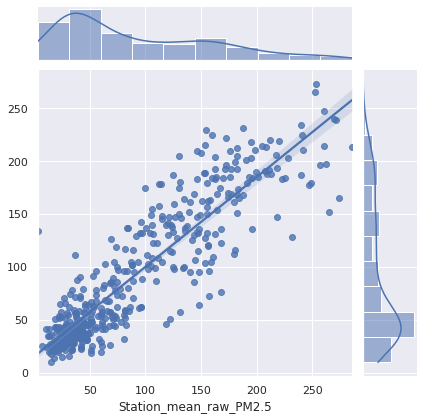

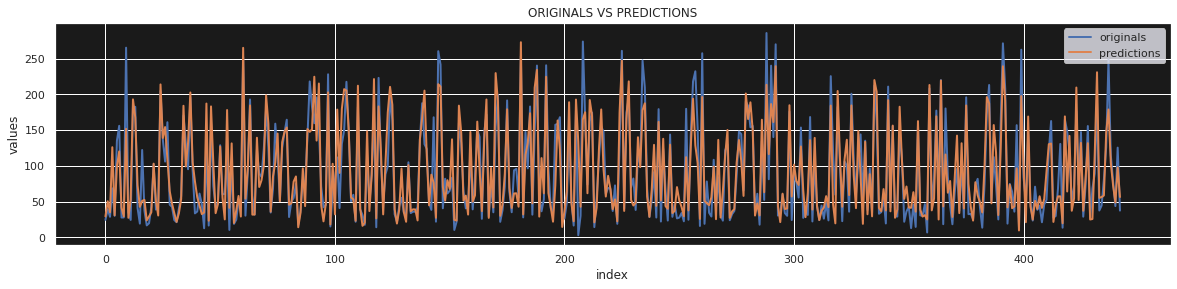

In [31]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
xgr =XGBRegressor(random_state=42)
model(xgr,X_train,y_train,X_test,y_test,"feat",True)

In [32]:
xgr_1=XGBRegressor(random_state=42,learning_rate = 0.03,
                max_depth = 9, n_estimators = 2000,n_jobs=-1,reg_alpha=0.005,gamma=0.1,subsample=0.7,colsample_bytree=0.9, colsample_bylevel=0.9, colsample_bynode=0.9)


XGBRegressor(base_score=None, booster=None, colsample_bylevel=0.9,
             colsample_bynode=0.9, colsample_bytree=0.9, gamma=0.1, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.03, max_delta_step=None, max_depth=9,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=-1, num_parallel_tree=None,
             random_state=42, reg_alpha=0.005, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7, tree_method=None,
             validate_parameters=None, verbosity=None)
***************************************************************************
ROOT MEAN SQUARED ERROR : 27.534814148152694
***************************************************************************
Performance on training data : 99.99969169550437
Performance on testing data : 82.84489530427024
***************************************************************************
CROSS VALIDATION 

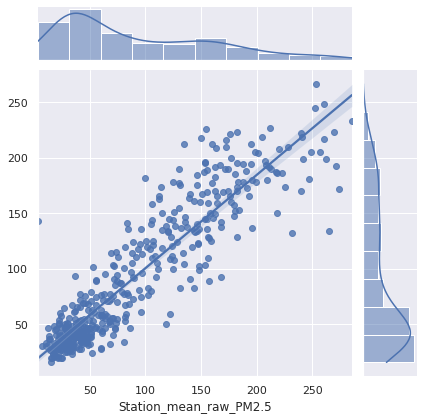

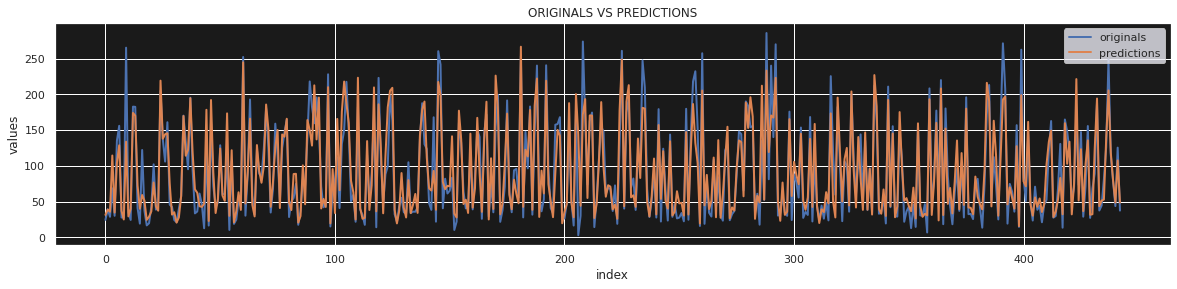

In [33]:
model(xgr_1,X_train,y_train,X_test,y_test,"feat",True)

In [34]:
from catboost import CatBoostRegressor

In [35]:
cb_model = CatBoostRegressor(iterations=2000,
                             learning_rate=0.03,
                             depth=9,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

***************************************************************************
0:	learn: 67.4206955	total: 59.3ms	remaining: 1m 58s
50:	learn: 33.7692883	total: 428ms	remaining: 16.4s
100:	learn: 26.6752681	total: 803ms	remaining: 15.1s
150:	learn: 24.0175993	total: 1.19s	remaining: 14.6s
200:	learn: 22.1501544	total: 1.56s	remaining: 14s
250:	learn: 20.6452911	total: 1.93s	remaining: 13.4s
300:	learn: 19.5540374	total: 2.3s	remaining: 13s
350:	learn: 18.5762573	total: 2.67s	remaining: 12.5s
400:	learn: 17.5061319	total: 3.14s	remaining: 12.5s
450:	learn: 16.5812127	total: 3.93s	remaining: 13.5s
500:	learn: 15.5902700	total: 4.47s	remaining: 13.4s
550:	learn: 14.7021539	total: 4.86s	remaining: 12.8s
600:	learn: 13.9415249	total: 5.29s	remaining: 12.3s
650:	learn: 13.2487963	total: 5.94s	remaining: 12.3s
700:	learn: 12.6544178	total: 6.31s	remaining: 11.7s
750:	learn: 12.0422524	total: 6.69s	remaining: 11.1s
800:	learn: 11.4780417	total: 7.06s	remaining: 10.6s
850:	learn: 10.9577722	total:

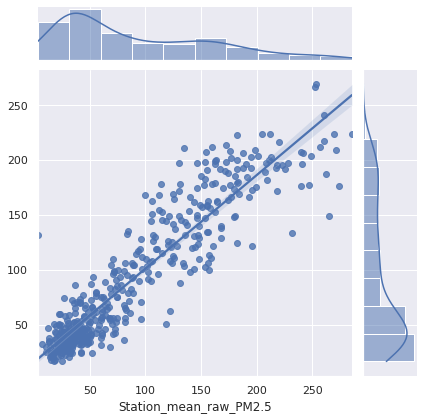

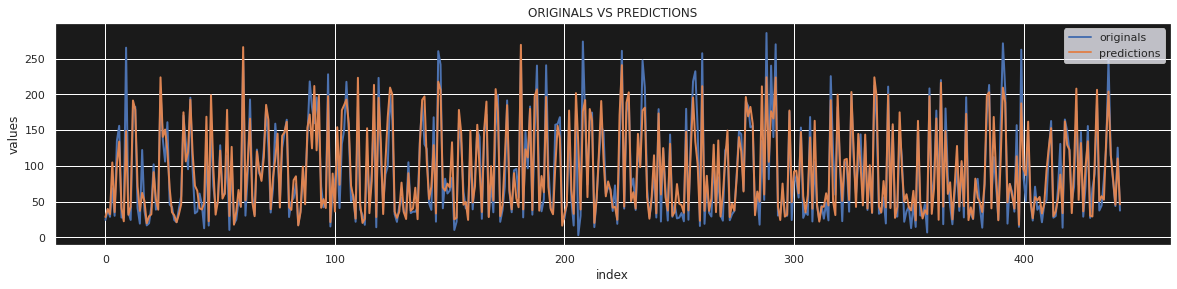

In [36]:
model(cb_model,X_train,y_train,X_test,y_test,"feat",True)

# Multiple Machine Learning Algorithm for Resgression

In [37]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [38]:
model_dict = {
    'LinearRegession': LinearRegression(),
    'Ridge':Ridge(),
    'Lasso':Lasso(),
    'KernelRidge':KernelRidge(),
    'SGDRegressor':SGDRegressor(),
    'BayesianRidge':BayesianRidge(),
    'ElasticNet': ElasticNet(),
    'LinearSVR':LinearSVR(),
    #Perfect Models this Problem
    'XGBRegressor':XGBRegressor(random_state=42, n_estimators=2000, max_depth=9),
    'RandomForestRegressor': RandomForestRegressor(random_state=0, n_estimators=2000, max_depth=9),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42, n_estimators=2000, max_depth=9, learning_rate=0.01)
}

In [39]:
data_list = list()
for name, model in model_dict.items():
    data_dict = dict()
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    data_dict['model'] = name
    data_dict['train_score'] = train_score
    data_dict['test_score'] = test_score
    data_list.append(data_dict)
score_df = pd.DataFrame(data_list)
score_df['score_diff'] = score_df['train_score'] - score_df['test_score']
model_df = score_df.sort_values(['test_score'], ascending=[False])
model_df[model_df['test_score'] > 0.5]

,model,train_score,test_score,score_diff
9,RandomForestRegressor,0.942959,0.830394,0.112565
5,BayesianRidge,0.781367,0.810324,-0.028957
1,Ridge,0.781372,0.810311,-0.028939
0,LinearRegession,0.781373,0.810299,-0.028926
2,Lasso,0.780097,0.808277,-0.028180
4,SGDRegressor,0.779971,0.808264,-0.028292
8,XGBRegressor,1.000000,0.807879,0.192121
7,LinearSVR,0.769688,0.806053,-0.036364
10,GradientBoostingRegressor,0.999982,0.798604,0.201378
6,ElasticNet,0.709891,0.738814,-0.028924


# Artificial Neural Networks(ANNs) Part:

In [40]:
# Building ANN As a Regressor
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras import backend

#Defining Root Mean Square Error As our Metric Function 
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


In [41]:
# Initialising the Artificial Neural Networks(ANNs)
model_nn = Sequential()

# Adding the input layer and the first hidden layer
model_nn.add(Dense(512, activation = 'relu', input_dim =  7))
model_nn.add(BatchNormalization())
# Adding the second hidden layer
model_nn.add(Dense(units = 256, activation = 'relu'))
model_nn.add(BatchNormalization())
# Adding the third hidden layer
model_nn.add(Dense(units = 256, activation = 'relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(units = 128, activation = 'relu'))
model_nn.add(BatchNormalization())
# Adding the output layer
model_nn.add(Dense(units = 1))

# Optimize , Compile And Train The Model 
opt =keras.optimizers.Adam(lr=0.003)
#print(model_nn.summary())
model_nn.compile(optimizer=opt,loss='mean_squared_error',metrics=[rmse])

In [42]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4096      
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [43]:
import tensorflow as tf
checkpoint_filepath ='best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_rmse',
    mode='min',
    save_best_only=True)

In [44]:
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history=model_nn.fit(sc.fit_transform(X_train),y_train,
                     epochs = 300,
                     batch_size=32,
                     validation_data=(sc.transform(X_test), y_test),
                     callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
model_nn.load_weights(checkpoint_filepath)

Epoch 1/300
33/33 [==============================] - 3s 26ms/step - loss: 13235.9485 - rmse: 97.4897 - val_loss: 10777.4326 - val_rmse: 92.2674
Epoch 2/300
33/33 [==============================] - 0s 6ms/step - loss: 10805.7980 - rmse: 93.0510 - val_loss: 9181.2334 - val_rmse: 87.7665
Epoch 3/300
33/33 [==============================] - 0s 6ms/step - loss: 8037.6176 - rmse: 82.3969 - val_loss: 6869.8730 - val_rmse: 76.5917
Epoch 4/300
33/33 [==============================] - 0s 6ms/step - loss: 6623.1768 - rmse: 74.6926 - val_loss: 6730.1074 - val_rmse: 74.7819
Epoch 5/300
33/33 [==============================] - 0s 6ms/step - loss: 5205.8692 - rmse: 64.4268 - val_loss: 4442.7471 - val_rmse: 55.5035
Epoch 6/300
33/33 [==============================] - 0s 6ms/step - loss: 3735.4500 - rmse: 53.6895 - val_loss: 1657.9120 - val_rmse: 30.2820
Epoch 7/300
33/33 [==============================] - 0s 6ms/step - loss: 2891.1658 - rmse: 43.1039 - val_loss: 1221.4385 - val_rmse: 24.3530
Epoch 8/3

In [45]:
# Predicting and Finding R Squared Score
y_predict = model_nn.predict(sc.transform(X_test))
print('Root Mean Squared Error is: ', np.sqrt(mean_squared_error(y_test, y_predict))) 


Root Mean Squared Error is:  24.86956556676629


In [46]:
tree_pred = model_nn.predict(X_test)
tree_mse = mean_squared_error(y_test,tree_pred)
tree_accuracy = r2_score(y_test,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('Overall model accuracy: {}'.format(tree_accuracy))

Root Mean Squared Error: 24.86956556676629

Overall model accuracy: 0.8600523946382177


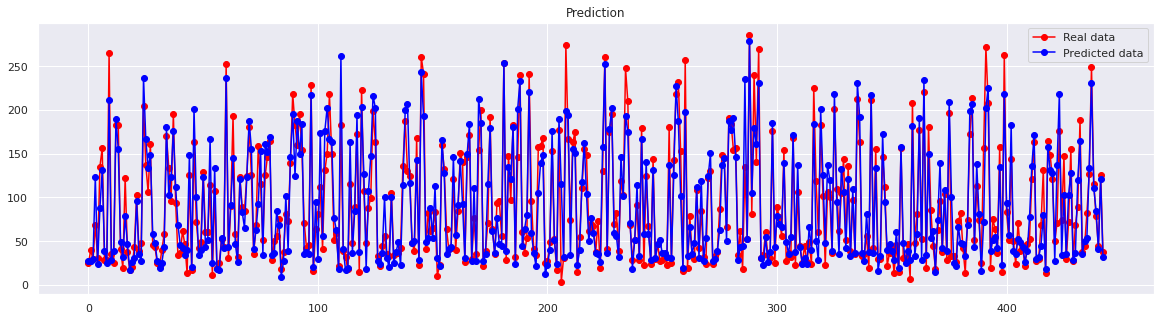

In [47]:
plt.figure(figsize=(20,5))
plt.plot(list(y_test) ,color = 'red', label = 'Real data',marker='o')
plt.plot(y_predict, color = 'blue', label = 'Predicted data',marker='o')
plt.title('Prediction')
plt.legend()
plt.show()

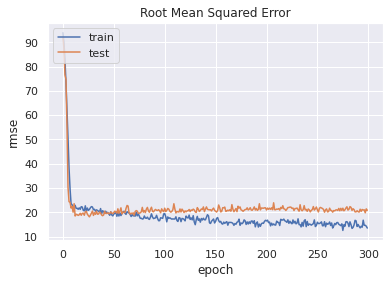

In [48]:
# Plotting Loss And Root Mean Square Error For both Training And Test Sets
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Root Mean Squared Error')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

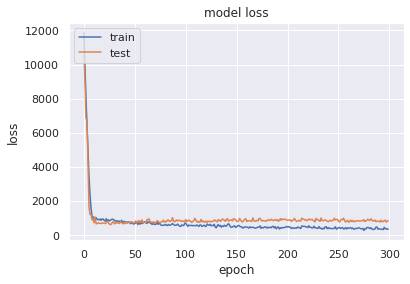

In [49]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()